In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from Model import Model
from config import get_config, get_tokenizer, get_preprocessed_sequence, get_causal_mask, get_tokenized_text, checkpoint#, visualize_attention_matrix#, get_preprocessed_sequence_pd_csv

ImportError: cannot import name 'visualize_attention_matrix' from 'config' (c:\Users\zac's\PERSONAL\vscode projects\llm\config.py)

loss visualization

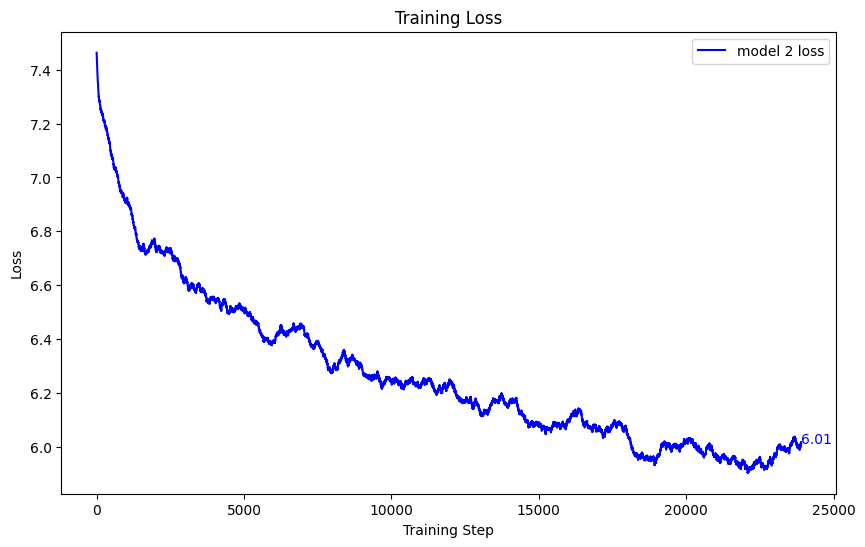

In [69]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
window_size = 1000
plt.figure(figsize=(10, 6))
max_length = len(pd.read_csv('saved/2/losses.csv')['losses'].values.tolist())

losses = pd.read_csv('saved/2/losses.csv')['losses'].values.tolist()[:max_length]
smoothed_losses = moving_average(losses, window_size)
plt.plot(smoothed_losses, label='model 2 loss', color='blue')
plt.annotate(f"{smoothed_losses[-1]:.2f}", xy=(len(smoothed_losses), smoothed_losses[-1]), textcoords="data", color='blue')

plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

model inference

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

config = get_config()
tokenizer, vocab_size = get_tokenizer()

loaded_model = Model(embed_dim=config["embed_dim"],
              num_blocks=config["num_blocks"], 
              num_heads=config["num_heads"], 
              ff_dim=config["ff_dim"], 
              # dropout_rate=conf["dropout_rate"],
              batch_size=config["batch_size"], 
              vocab_size=vocab_size).to(device)
loaded_model.load_state_dict(torch.load('saved/2/model.pth'))
loaded_model.eval()

# inference should k means sort picking(or something like that, like it should pick based on the tokens confidences as percentages * constant)<-------------

tokenized_text = get_tokenized_text(tokenizer, device)
# sequence = tokenized_text[random.randint(0, tokenized_text.shape[0]-1)].view(1, -1)
# sequence = tokenized_text[0].view(1, -1)
sequence = torch.tensor(tokenizer("[START]The")['input_ids']).view(1, -1).to(device)
# print(sequence, sequence.shape)

while sequence[0][-1].item() != tokenizer("[END]")['input_ids'][0] and sequence.shape[-1] < 100:
    causal_mask = get_causal_mask((sequence.shape[1], sequence.shape[1]), device)
    logits, probs = loaded_model(sequence, key_padding_mask = None, causal_mask = causal_mask) # dont really need causal_mask
    predicted_token = torch.argmax(probs[0][-1], dim=-1).view(1, -1)
    sequence = torch.cat((sequence, predicted_token), dim=-1)
print(''.join(map(str, [tokenizer.decode(token.item()) for token in sequence[0]])))

cuda


Token indices sequence length is longer than the specified maximum sequence length for this model (338027 > 1024). Running this sequence through the model will result in indexing errors


[START]The debate is closed.[END]


In [ ]:
train_df = pd.read_csv('datasets/wmt14_translate_de-en_train.csv',lineterminator='\n')

attention visualization

cuda


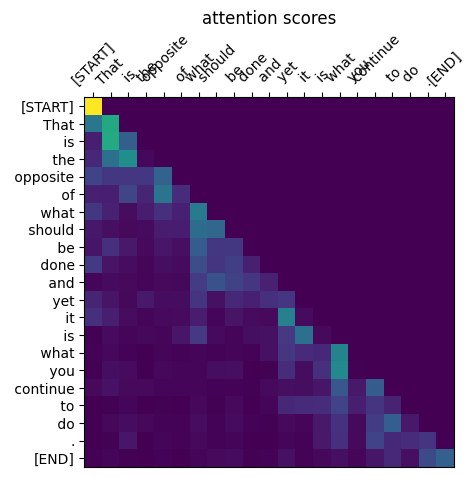

In [80]:
def get_preprocessed_sequence_pd_csv(step, train_df, tokenizer, device):
    sequence = train_df.iloc[step]['en']
    sequence = '[START]' + sequence + '[END]'
    tokenized_sequence = tokenizer(sequence, max_length = 1024, truncation = True)['input_ids']
    return torch.tensor(tokenized_sequence).to(device)

def visualize_attention_matrix(attention_matrix, sequence, tokenizer):
    sequence = sequence.squeeze(0)
    attention_matrix = attention_matrix.squeeze(0)
    attention_matrix = np.mean(np.array(attention_matrix.cpu().detach().numpy()), axis=(0))# average over heads within each layer
    attention_matrix = np.clip((attention_matrix - attention_matrix.min()) / (attention_matrix.max() - attention_matrix.min()), 0, 1)

    fig, ax = plt.subplots()
    im = ax.imshow(attention_matrix, cmap='viridis')
    ax.set_xticks(np.arange(len(sequence)))
    ax.set_yticks(np.arange(len(sequence)))
    ax.set_xticklabels([tokenizer.decode([token.item()]) for token in sequence], rotation=45)
    ax.set_yticklabels([tokenizer.decode([token.item()]) for token in sequence])
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_title('attention scores')
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

config = get_config()
tokenizer, vocab_size = get_tokenizer()

loaded_model = Model(embed_dim=config["embed_dim"],
              num_blocks=config["num_blocks"], 
              num_heads=config["num_heads"], 
              ff_dim=config["ff_dim"], 
              # dropout_rate=conf["dropout_rate"],
              batch_size=config["batch_size"], 
              vocab_size=vocab_size).to(device)
loaded_model.load_state_dict(torch.load('saved/2/model.pth'))
loaded_model.eval()

# inference should k means sort picking(or something like that, like it should pick based on the tokens confidences as percentages * constant)<-------------

# train_df = pd.read_csv('datasets/wmt14_translate_de-en_train.csv',lineterminator='\n')
sequence = get_preprocessed_sequence_pd_csv(0, train_df, tokenizer, device).unsqueeze(0)

causal_mask = get_causal_mask((sequence.shape[1], sequence.shape[1]), device)
logits, probs = loaded_model(sequence, key_padding_mask = None, causal_mask = causal_mask) # dont really need causal_mask
attention_matrix = loaded_model.decoder.blocks[0].attention.last_attention
visualize_attention_matrix(attention_matrix, sequence, tokenizer)

validation loss